In [84]:
import datetime
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import time
import xgboost as xgb

In [85]:
import sys
sys.path.append('../../../')

from src.predictor_util import modelfit
from src.plot_utils import plot_confusion_matrix, analysing_feature_importance
from src.transformer_utils import encode_labels

## 1. Chargement des Dataset

In [86]:
df_drivers = pd.read_csv('../../../data/db/01_driver.csv')
df_constructors = pd.read_csv('../../../data/db/02_constructors.csv')
df_races_results = pd.read_csv('../../../data/outputs/03_races_results.csv')
df_circuits= pd.read_csv('../../../data/outputs/02_circuits_processed.csv')

## 2. Fusion des datasets

In [87]:
df = df_races_results.merge(df_drivers, on='driverId', how='inner')
df.head()

,resultId,raceId,driverId,constructorId,grid,race_rank,points,laps,milliseconds,fastestLap,...,race_end_in_2017,race_end_in_2018,race_end_in_2019,race_end_in_2020,race_end_in_2021,race_end_in_2022,race_end_in_2023,driver_most_won_circuit_id,driver_nber_of_races_won,driver_nber_of_times_in_top_10
0,1,18,1,1,1,1,10.0,58,5690616,39,...,19,20,21,16,21,19,12,9,103,283
1,2,18,2,2,5,2,8.0,58,5696094,41,...,0,0,0,0,0,0,0,0,0,101
2,3,18,3,3,7,3,6.0,58,5698779,41,...,0,0,0,0,0,0,0,6,23,144
3,4,18,4,4,11,4,5.0,58,5707797,58,...,3,5,0,0,11,12,12,3,32,250
4,5,18,5,1,3,5,4.0,58,5708630,43,...,0,0,0,0,0,0,0,11,1,36


In [88]:
df = df.merge(df_constructors, on='constructorId', how='inner')
df.head()

,resultId,raceId,driverId,constructorId,grid,race_rank,points,laps,milliseconds,fastestLap,...,race_end_in_2023,driver_most_won_circuit_id,driver_nber_of_races_won,driver_nber_of_times_in_top_10,constructor_name,constructor_country,constructor_is_active,constructor_races_won,constructor_avg_point,constructor_times_in_top_10
0,1,18,1,1,1,1,10.0,58,5690616,39,...,12,9,103,283,McLaren,British,1,179,3.364151,1110
1,2,18,2,2,5,2,8.0,58,5696094,41,...,0,0,0,101,BMW Sauber,German,0,1,2.200000,91
2,3,18,3,3,7,3,6.0,58,5698779,41,...,0,6,23,144,Williams,British,1,114,2.243008,764
3,4,18,4,4,11,4,5.0,58,5707797,58,...,12,3,32,250,Renault,French,0,35,2.257942,390
4,5,18,5,1,3,5,4.0,58,5708630,43,...,0,11,1,36,McLaren,British,1,179,3.364151,1110


In [89]:
df = df.merge(df_circuits[['circuitId', 'circuits_is_active']], on='circuitId', how='inner')
df.head()

,resultId,raceId,driverId,constructorId,grid,race_rank,points,laps,milliseconds,fastestLap,...,driver_most_won_circuit_id,driver_nber_of_races_won,driver_nber_of_times_in_top_10,constructor_name,constructor_country,constructor_is_active,constructor_races_won,constructor_avg_point,constructor_times_in_top_10,circuits_is_active
0,1,18,1,1,1,1,10.0,58,5690616,39,...,9,103,283,McLaren,British,1,179,3.364151,1110,1
1,2,18,2,2,5,2,8.0,58,5696094,41,...,0,0,101,BMW Sauber,German,0,1,2.200000,91,1
2,3,18,3,3,7,3,6.0,58,5698779,41,...,6,23,144,Williams,British,1,114,2.243008,764,1
3,4,18,4,4,11,4,5.0,58,5707797,58,...,3,32,250,Renault,French,0,35,2.257942,390,1
4,5,18,5,1,3,5,4.0,58,5708630,43,...,11,1,36,McLaren,British,1,179,3.364151,1110,1


## 2. Retirer les colonnes non importantes

L'objectifs ici étant de garder les caractéristiques étant fortement corrélées avec la variable à prédire (race_rank)

In [90]:
df = df[df.year >= 2018]

In [91]:
# Colonnes non corrolées
not_corr_cols = ['constructorId', 'raceId', 'resultId', 'year', 'round', 'circuitId', 'age', 'driver_most_won_circuit_id']

# Retirer comme à la base les variable de base n'étant pas fortement corrélées
df = df.drop(not_corr_cols, axis=1)

In [92]:
# Selection des colonnes de types objets puis suppression car le modèle ne lit pas ce type de données
cols = df.select_dtypes(np.object_).columns.to_list()
df = df.drop(cols, axis=1)

In [93]:
df.head()

,driverId,grid,race_rank,points,laps,milliseconds,fastestLap,fastestLapTime,fastestLapSpeed,statusId,...,race_end_in_2021,race_end_in_2022,race_end_in_2023,driver_nber_of_races_won,driver_nber_of_times_in_top_10,constructor_is_active,constructor_races_won,constructor_avg_point,constructor_times_in_top_10,circuits_is_active
23777,20,3,1,25.0,58,5373283,53,86469,220.782,1,...,6,13,0,53,220,1,243,4.343429,1614,1
23778,1,1,2,18.0,58,5378319,50,86444,220.845,1,...,21,19,12,103,283,1,125,12.259658,483,1
23779,8,2,3,15.0,58,5379592,57,86373,221.027,1,...,5,0,0,21,232,1,243,4.343429,1614,1
23780,817,8,4,12.0,58,5380352,54,85945,222.128,1,...,13,14,1,8,131,1,104,9.461111,530,1
23781,4,10,5,10.0,58,5401169,57,86978,219.489,1,...,11,12,12,32,250,1,179,3.364151,1110,1


## 3. Encodage des colonnes catégorielles

In [94]:
df = encode_labels(df, ['grid', 'race_rank', 'laps', 'fastestLap', 'statusId'])

## 4. Entraînement du modèle

In [95]:
target = 'race_rank'
features = [x for x in df.columns if x not in [target]]

In [96]:
# Instantiation du modèle de classification
xgb_model = xgb.XGBClassifier(
    n_estimators=205,
    learning_rate=0.001,
    max_depth=120,
    eta= 0.18,
    subsample= .8,
    colsample_bytree= 0.8,
    objective= 'multi:softmax',
    eval_metric='merror',
    min_child_weight = 9,
    gamma = 0,
    n_jobs=-1,
    num_class= 25,
    enable_categorical=True,
    seed=80,
)

In [97]:
start = time.time()

model = modelfit(df, features, target, xgb_model)

end = time.time()
print(f"\nProcess time: {str(datetime.timedelta(seconds=(end - start)))}")


Model Report
Accuracy : 0.5986
AUC Score (Train): 0.954232
AUC Score (Test): 0.922951

Process time: 0:00:05.599674


## 5. Analyse des sorties du modèle

### 5.1. Rapport de classification

In [98]:
print("Classification Report:")
print(model[4])

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        40
           1       1.00      0.87      0.93        45
           2       0.93      1.00      0.96        41
           3       1.00      1.00      1.00        32
           4       1.00      0.96      0.98        26
           5       1.00      1.00      1.00        40
           6       1.00      1.00      1.00        34
           7       0.96      0.96      0.96        28
           8       0.97      0.97      0.97        30
           9       0.97      1.00      0.99        34
          10       0.14      0.50      0.22        24
          11       0.14      0.10      0.11        42
          12       0.25      0.03      0.05        38
          13       0.13      0.14      0.14        28
          14       0.20      0.05      0.09        37
          15       0.17      0.33      0.22        33
          16       0.15      0.06      0.09        33
    

### 5.2. Matrix de Confusion

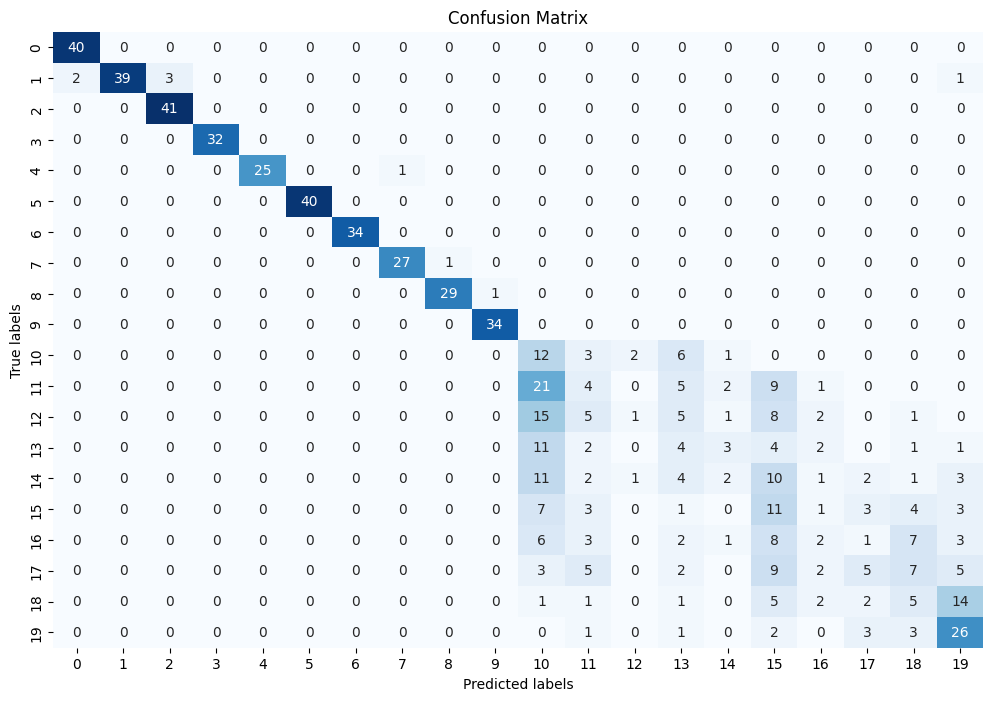

In [99]:
plot_confusion_matrix((model[1], model[2]))

### 5.3. Feature importance

In [100]:
feature_imp_serie = pd.Series(model[0].get_booster().get_fscore()).sort_values(ascending=False)

In [101]:
analysing_feature_importance(feature_imp_serie)

## 6. Boostons le model avec la validation croisée

In [102]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.30, random_state=48)

In [103]:
# # Paramètre de la validation croisée
# param_grid = {
#     'n_estimators': [100, 200, 300],            # Nombre d'argre de XGBoost
#     'max_depth': [6, 20, 75],                   # Profondeur maximal d'un arbre
#     'learning_rate': [0.01, 0.05, 0.1],         # Taux d'apprentissage
#     'gamma': [0, 0.1, 0.2],                     # Le minimum de perte requis pour plus de partitionnement
#     'subsample': [0.6, 0.8, 1.0],               # Ke sous échantillon des instances d'entrainement
#     'colsample_bytree': [0.6, 0.8, 1.0]         # Le sous échantillon de colonne lorsque l'on construit chaque arbre
# }

# random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=50,
#                                    scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1)

# # Effectuons la validation croisée
# random_search.fit(X_train, y_train)
# #  Récupération des meilleurs paramètres et du score
# print("Best parameters found: ", random_search.best_params_)
# print("Best accuracy found: ", random_search.best_score_)

# # Evaluation du meilleur model en test
# best_model = random_search.best_estimator_
# test_accuracy = best_model.score(X_test, y_test)
# print("Test accuracy of the best model: ", test_accuracy)

# Save the model

In [104]:
start = time.time()

model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    eta= 0.18,
    subsample= 1.0,
    colsample_bytree= 0.8,
    objective= 'multi:softmax',
    eval_metric='merror',
    min_child_weight = 9,
    gamma = 0.1,
    n_jobs=-1,
    num_class= 25,
    enable_categorical=True,
    seed=80,
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Best accuracy found: ", accuracy)
end = time.time()
print(f"\nProcess time: {str(datetime.timedelta(seconds=(end - start)))}")

with open("../../../models/v0.1/modelv01.pkl", "wb") as f:
    pickle.dump(model, f)

Best accuracy found:  0.5811594202898551

Process time: 0:00:02.966015
